In [166]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
#Getting data
dataset_path = 'dataset/Metro_Interstate_Traffic_Volume.csv'
raw_dataset = pd.read_csv(dataset_path)

In [3]:
raw_dataset.head()  #resume of data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
raw_dataset.describe() #Basic insights

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [5]:
raw_dataset.info()  #info about data type, number of instances, etc.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


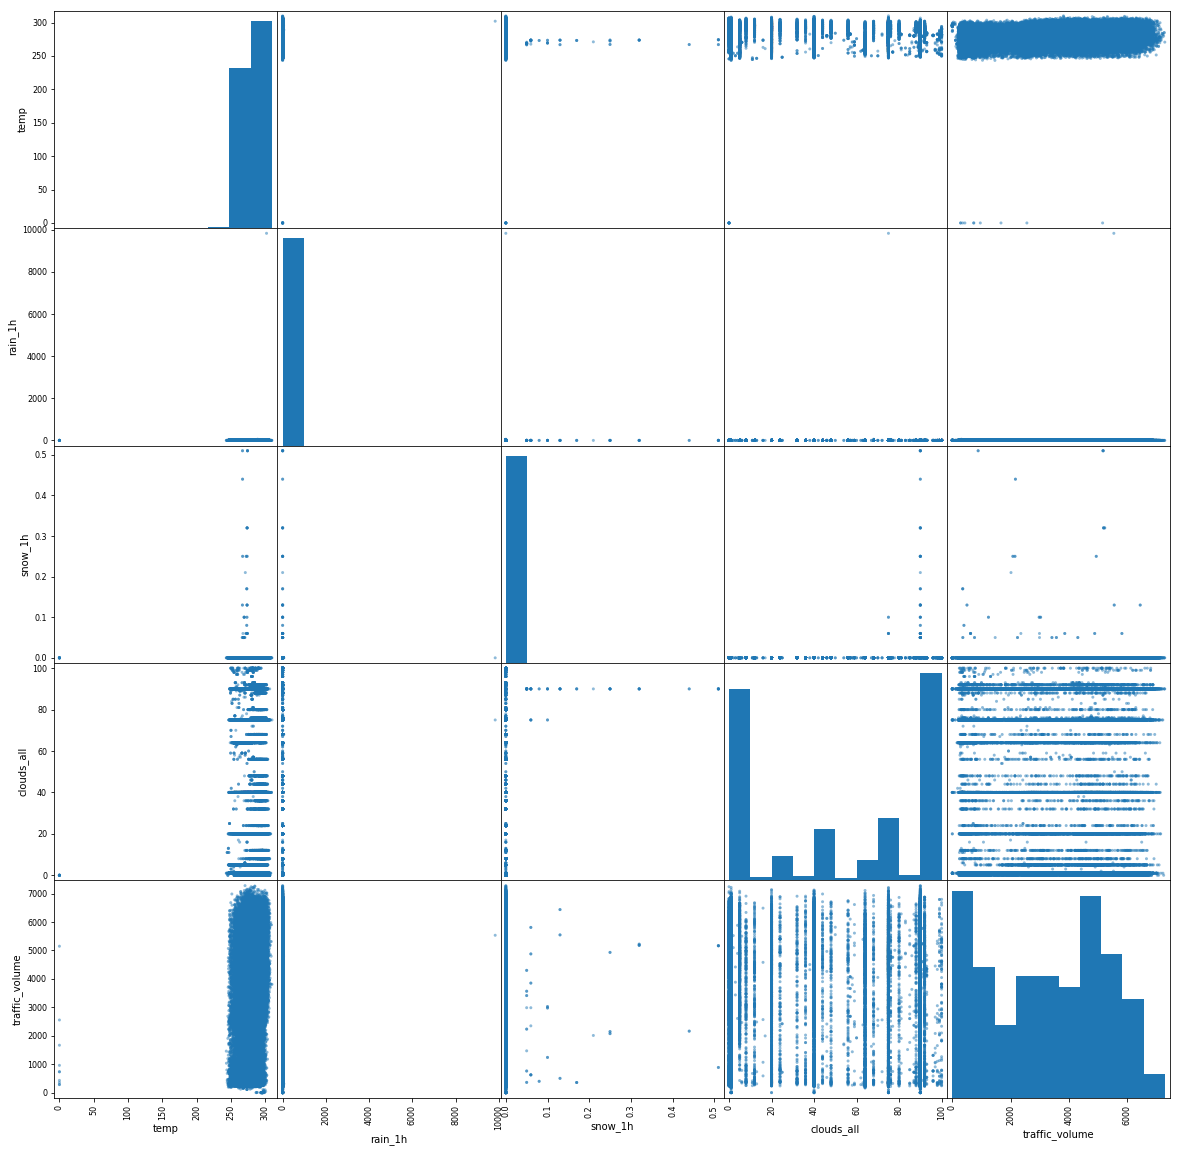

In [9]:
scatter_matrix(raw_dataset, figsize=(20, 20))   #plotting scatter correlation between numerical variables
plt.show()

In [16]:
raw_dataset['date_time'] = pd.to_datetime(raw_dataset['date_time'])

In [33]:
raw_dataset['day'] = raw_dataset['date_time'].map(lambda x: x.day)
raw_dataset['month'] = raw_dataset['date_time'].map(lambda x: x.month)
raw_dataset['year'] = raw_dataset['date_time'].map(lambda x: x.year)
raw_dataset['hour'] = raw_dataset['date_time'].map(lambda x: x.hour)
raw_dataset['year_month_day_hour'] = raw_dataset['date_time'].map(lambda x: x.year*1000000 + x.month*10000 + x.day*100 + x.hour)

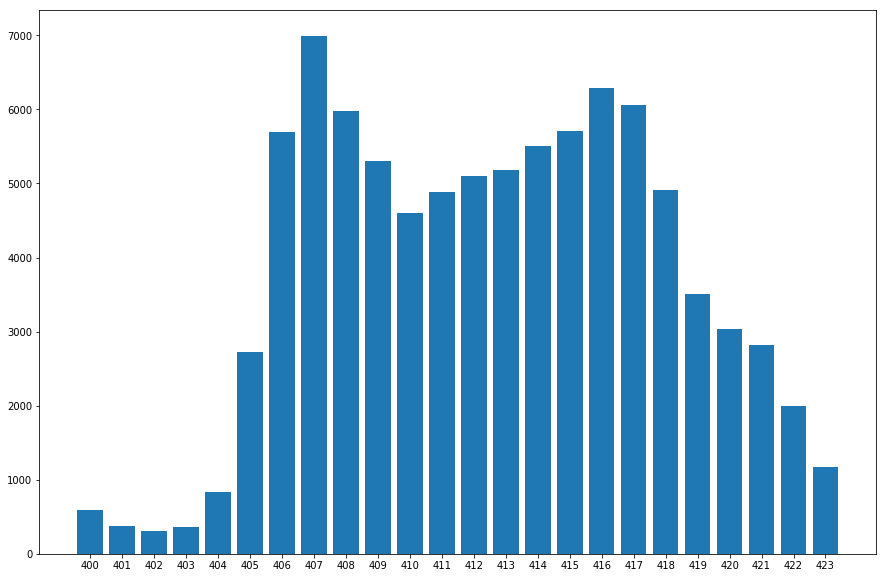

In [67]:
x = raw_dataset['date_time'][35:59].map(lambda x: x.day*100 + x.hour)
y = raw_dataset['traffic_volume'][35:59]
plt.figure(figsize=(15,10))
plt.bar(x,y, width = 0.8)
plt.xticks(x)
plt.show()

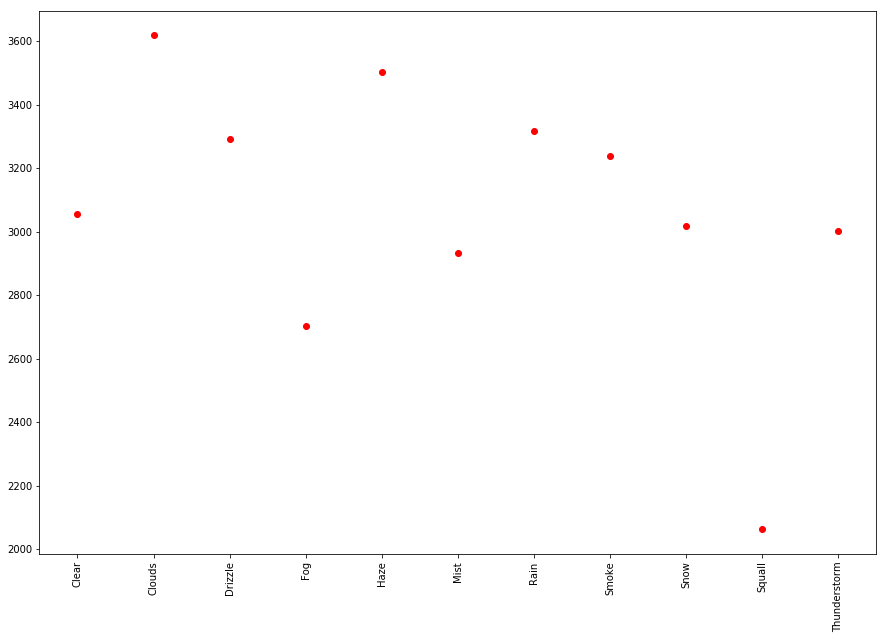

In [135]:
x = raw_dataset['rain_1h']
y = raw_dataset['traffic_volume'].groupby(raw_dataset['weather_main']).mean()

#plt.xticks(np.arange(0, 50, 0.1)) 
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
#plt.xlim(240,300)
plt.plot(y,'ro')
plt.show()

In [148]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self._feature_names = feature_names
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X[self._feature_names]

In [150]:
#Selecting numerical features and processing
numerical_pipeline = Pipeline([
    ('select_numeric',FeatureSelector(['temp','rain_1h','snow_1h','clouds_all','day','month','year','hour']))
])

In [151]:
#Selecting categorical features and processing
categorical_pipeline = Pipeline([
    ('select_categoric',FeatureSelector(['holiday','weather_main','weather_description'])),
    ('cat_encoder',OneHotEncoder(sparse=False))
])

In [152]:
#Selecting label feature
label_pipeline = Pipeline([
    ('select_label',FeatureSelector(['traffic_volume']))
])

In [153]:
#Join all pipeline
preprocess_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline',numerical_pipeline),
    ('cat_pipeline',categorical_pipeline)
])

X_data = preprocess_pipeline.fit_transform(raw_dataset)
y_data = label_pipeline.fit_transform(raw_dataset)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.20, random_state = 42)

In [155]:
tree_clf = DecisionTreeRegressor()
tree_clf.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [156]:
tree_clf.predict(X_test)

array([1212., 2225.,  775., ..., 3246., 1664.,  795.])

In [157]:
tree_clf.score(X_test,y_test)

0.6814726264363311

In [160]:
linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)
linear_reg.score(X_test,y_test)

0.15575773084138433

In [163]:
random_reg = RandomForestRegressor(n_estimators = 100)
random_reg.fit(X_train,y_train)
random_reg.score(X_test,y_test)

c:\users\alexf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8371615899732617

In [165]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train,y_train)
sgd_reg.score(X_test,y_test)

c:\users\alexf\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\alexf\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-1.1710474512158048e+22

In [168]:
print(cross_val_score(random_reg, X_train, y_train, cv=5, n_jobs = -1))  

[0.83090457 0.8255811  0.83455998 0.82100325 0.81982148]
